In [21]:
import os
import sys
import datetime 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import IsolationForest

import warnings
#warnings.filterwarnings("ignore")
%matplotlib inline

## Data Preparation

In [22]:
def read_data(path, date_col):                              #* date_col is a list

    data = pd.read_csv(path,
                            parse_dates={'Date_parsed' : date_col},
                            infer_datetime_format=True,
                            on_bad_lines='warn',
                            skip_blank_lines=True)

    try:
        df = data.dropna(axis=0, subset=['Date_parsed'])
        df = df.set_index('Date_parsed')
        df = df.sort_index()
        #df = df.drop(columns=date_col)
    except:
        print("Unexpected error:", sys.exc_info()[0])

    print(df)
    print('\n', df.dtypes)
    return df

In [23]:
path = '../data/processed/Bearing_Nasa_data.csv'
date_col = []
date_col.append('Unnamed: 0')                               #! Get from UI - Empty if no Date

bearing_data = read_data(path, date_col)

                     Bearing 1  Bearing 2  Bearing 3  Bearing 4
Date_parsed                                                    
2004-02-12 10:52:39   0.060236   0.074227   0.083926   0.044443
2004-02-12 11:02:39   0.061455   0.073844   0.084457   0.045081
2004-02-12 11:12:39   0.061361   0.075609   0.082837   0.045118
2004-02-12 11:22:39   0.061665   0.073279   0.084879   0.044172
2004-02-12 11:32:39   0.061944   0.074593   0.082626   0.044659
...                        ...        ...        ...        ...
2004-02-19 05:42:39   0.453335   0.161016   0.137440   0.119047
2004-02-19 05:52:39   0.337583   0.132400   0.144992   0.092125
2004-02-19 06:02:39   0.351111   0.152266   0.151299   0.100817
2004-02-19 06:12:39   0.001857   0.003732   0.003656   0.001786
2004-02-19 06:22:39   0.001168   0.000767   0.000716   0.001699

[982 rows x 4 columns]

 Bearing 1    float64
Bearing 2    float64
Bearing 3    float64
Bearing 4    float64
dtype: object


In [24]:
def nan(df):
    print("Process Nan...")
    df_numeric = df.select_dtypes(include=[np.number])
    numeric_cols = df_numeric.columns.values
    for col in numeric_cols:
        pct_missing = np.mean(df[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))
        if pct_missing < 4:                                             #* if NaN < 4% : replace by median
            med = df[col].median()
            df[col] = df[col].fillna(med)
        if pct_missing >= 20:                                           #* if NaN > 20% : drop features
            df = df.drop(columns=[col])
        if (pct_missing < 20) & (pct_missing >= 4) :                    #* if NaN < 20% & > 4% : drop lines
            df = df.dropna(subset=[col])

    df_non_numeric = df.select_dtypes(exclude=[np.number])              #* Repeat process with non numerics variables
    non_numeric_cols = df_non_numeric.columns.values
    for col in non_numeric_cols:
        pct_missing = np.mean(df[col].isnull())
        print('{} - {}%'.format(col, round(pct_missing*100)))
        if pct_missing < 4:
            med = df[col].median()
            df[col] = df[col].fillna(med)
        if pct_missing >= 20:
            df = df.drop(columns=[col])
        if pct_missing < 20 :
            df = df.dropna(subset=[col])
    print(df.shape)
    return df

def fix_typos(df):
    print("Fixing Typos...")
    obj = [col  for col, dt in df.dtypes.items() if dt == object]
    for col in obj:
        df[obj] = df[obj].str.replace(',', '.')
        df[obj] = df[obj].str.upper()
        df[obj] = df[obj].str.strip()
    print(df.shape)
    return df

def dummification(df, cat=None):                                        #* cat is a list
    if cat is not None:
        print("Encoding categorical varible(s)...")
        pd.get_dummies(data=df, columns=cat)
    print(df.shape)
    return df

def drop_bad_periods(df, mult_var=None, l_periods:dict=None):                #* l_periods is a dict
    if l_periods is not None:
        print("Removing Time periods...")
        for key, value in l_periods.items():
            if (mult_var is not None) & (len(mult_var) != 0):
                df = df[~(df.index.strftime('%Y-%m-%d').isin(value) & df[mult_var == key])]
            else:
                df = df[~(df.index.strftime('%Y-%m-%d').isin(value))]
    print(df.shape)                                                     
    return df

def drop_date(df, dow=None, month=None):                                #* dow and month are list
    if dow is not None:
        print("Removing day of week...")
        mask = df.index.dayofweek.isin(dow)
        df = df[~mask]                                         
    if month is not None:
        print("Removing useless month...")
        mask = df.index.month.isin(month)
        df = df[~mask]  
    print(df.shape)
    return df

def custom_rules(df, column:str, value):                                    #! make custom filter (depend on UI)
    if type(value) == list:
        if value[0] == str:
            return df[df[column].isin(value)]
        else:
            return df[(df[column] >= value[0]) & (df[column] >= value[1])]
    else:
        return df[df[column]==value]

In [25]:
dow, month = None, None                                                             #! Get from UI
cat = None                                                                          #! Get from UI
mult_var = None                                                                     #! Get from UI
l_periods = None                                                                    #! Get from UI

def data_prep(df, dow=None, month=None, cat=None, mult_var=None, l_periods=None):
    df = drop_bad_periods(df, mult_var=mult_var, l_periods=l_periods)               #* Drop periods selected
    df = drop_date(df, dow=dow, month=month)                                        #* Drop useless date
    df = df.drop_duplicates(keep='last')                                            #* Keep only most recent duplicatas
    df = fix_typos(df)                                                              #* Set a good typos for categorical features
    df = dummification(df, cat=None)                                                #* Encode categorical variables 
    df = df.convert_dtypes()                                                        #* Assign good type for the modelling phase
    df = df.select_dtypes(exclude=['object'])                                       #* Remove Object and String columns who are irrelevant
    df = nan(df)                                                                    #* Process empty values based on several conditions
    df = df.convert_dtypes()                                                        #* Assign good type for the modelling phase
                                                    
    print('\n', df.dtypes)
    return df

data_cleaned = data_prep(bearing_data, dow=dow, month=month, cat=cat, mult_var=mult_var, l_periods=l_periods)
data_cleaned

(982, 4)
(982, 4)
Fixing Typos...
(982, 4)
(982, 4)
Process Nan...
Bearing 1 - 0%
Bearing 2 - 0%
Bearing 3 - 0%
Bearing 4 - 0%
(982, 4)

 Bearing 1    Float64
Bearing 2    Float64
Bearing 3    Float64
Bearing 4    Float64
dtype: object


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
Date_parsed,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659
...,...,...,...,...
2004-02-19 05:42:39,0.453335,0.161016,0.13744,0.119047
2004-02-19 05:52:39,0.337583,0.1324,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817


In [26]:
train, test = train_test_split(data_cleaned, test_size=0.25, shuffle=False)
print('Test shape : {}    -   Train shape : {}'.format(test.shape, train.shape))        
print(train.tail(1).index)
print(test.head(1).index)

Test shape : (246, 4)    -   Train shape : (736, 4)
DatetimeIndex(['2004-02-17 13:22:39'], dtype='datetime64[ns]', name='Date_parsed', freq=None)
DatetimeIndex(['2004-02-17 13:32:39'], dtype='datetime64[ns]', name='Date_parsed', freq=None)


## Clustering Model

In [56]:
def custom_silhouette(estimator, X):
      sil_score = silhouette_score(X, estimator.predict(X))
      print("{}   -     ".format(round(sil_score, 4)), end = '')
      return sil_score

def custom_DBScrore(estimator, X):
      davboul_score = davies_bouldin_score(X, estimator.predict(X))
      print("{}   -     ".format(round(davboul_score, 4)), end = '')
      return davboul_score
      

clf = IsolationForest(random_state=42)

# Define the parameter grid for the hyperparameters that will be randomly sampled
param_grid = {
      'n_estimators': list(range(100, 1000, 10)),     
      'bootstrap': [True, False]
      }   

# Define the hyperparameter that will be tried for every possible valu
fixed_param = {
      'contamination': np.arange(0.0, 0.1, 0.01)
      }

# Combine the parameter grid and the fixed hyperparameter into a single dictionary
param_grid.update(fixed_param)     

grid_isol = RandomizedSearchCV(clf, 
                                param_grid,
                                scoring=custom_silhouette,              #? Davies Bouldin Score     or      Silhouette Score  
                                refit=True,
                                cv=3, 
                                return_train_score=True)

best_model = grid_isol.fit(train.values)

0.3074   -     0.7679   -     0.3579   -     0.7587   -     0.0494   -     0.3239   -     0.2737   -     0.7648   -     0.4481   -     0.7644   -     0.0763   -     0.3188   -     0.2915   -     0.7882   -     0.3993   -     0.7648   -     0.1011   -     0.3213   -     0.2094   -     0.739   -     0.4772   -     0.7305   -     0.1756   -     0.385   -     0.2545   -     0.7721   -     0.4481   -     0.7475   -     0.0645   -     0.3381   -     0.2193   -     0.728   -     0.4772   -     0.7193   -     0.1372   -     0.3966   -     0.2545   -     0.7853   -     0.4481   -     0.7475   -     0.0645   -     0.3381   -     0.2138   -     0.691   -     0.6801   -     0.2182   -     0.4135   -     0.2643   -     0.7853   -     0.4772   -     0.7764   -     0.1065   -     0.3374   -     0.2468   -     0.756   -     0.4772   -     0.7322   -     0.0977   -     0.3666   -     

In [57]:
custom_silhouette(best_model, train.values)
custom_DBScrore(best_model, train.values)
print('\nOptimum parameters', best_model.best_params_)

y_pred = best_model.predict(train.values)
train_clustered = train.assign(Cluster=y_pred)
train_clustered = train_clustered.replace({-1: "Anomaly", 1: "Regular"})
train_clustered["Cluster"].value_counts()

0.8279   -     0.183   -     
Optimum parameters {'n_estimators': 810, 'contamination': 0.04, 'bootstrap': True}


Regular    706
Anomaly     30
Name: Cluster, dtype: int64

### Save Model 

In [29]:
train_Bearing_Nasa = train_clustered[train_clustered['Cluster'] == "Regular"]
train_Bearing_Nasa = train_clustered.drop(columns=['Cluster'])
train_Bearing_Nasa.to_csv('../data/processed/train_Bearing_Nasa.csv')
test.to_csv('../data/processed/test_Bearing_Nasa.csv')

### Print Anomalies

In [58]:
fig = px.scatter_matrix(train_clustered,
    dimensions=["Bearing 1", "Bearing 2", "Bearing 3", "Bearing 4"],
    color="Cluster")
fig.show()

In [31]:
train_clustered = train_clustered.sort_index()

fig = make_subplots(rows=2, cols=2)

fig.add_trace(
    go.Scatter(x=train_clustered.index, y=train_clustered['Bearing 1']),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=train_clustered.index, y=train_clustered['Bearing 2']),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=train_clustered.index, y=train_clustered['Bearing 3']),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=train_clustered.index, y=train_clustered['Bearing 4']),
    row=2, col=2
)
    
#fig = px.line(train_clustered, y='Bearing 1', color='Cluster', markers=True)
fig.show()

In [59]:
fig = px.line(train_clustered, y='Bearing 2', color='Cluster', markers=True)
fig.show()

In [33]:
train_clustered['Cluster'] = train_clustered['Cluster'].astype('category')

## Data Viz

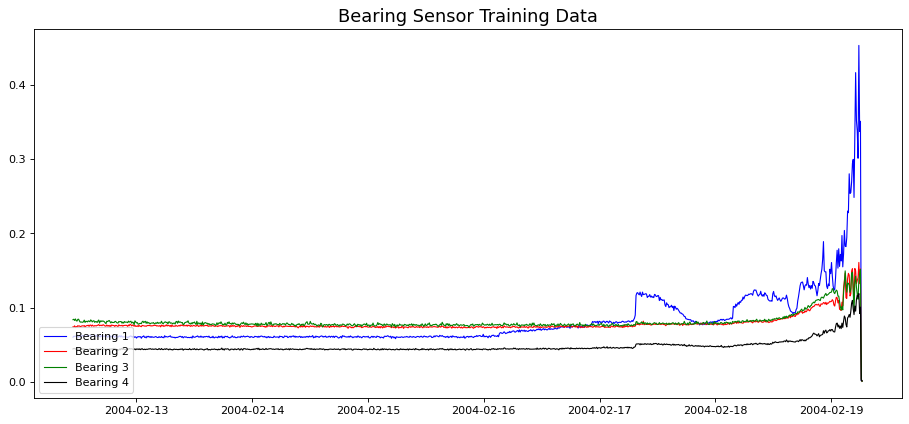

In [34]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(bearing_data['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(bearing_data['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(bearing_data['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(bearing_data['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()